# Introduction
This is the 2021 version of the notebook created by the [Information Systems Lab](http://islab.uom.gr) to introduce students of the [University of Macedonia](http://www.uom.gr), Greece to Machine Learning & Data Science.

The notebook has been created to use in a RAPIDS environment. In particular in has been developed in a 16 vCPUs, 60 GB RAM, and 1 NVIDIA Tesla T4 GPU in Google Cloud Platform.

## The Instacart competition
Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample dataset of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was participants to **predict which previously purchased products will be in a user’s next order**.

## Objective
The objective of this Kernel is to introduce students to predictive business analytics with Python through the Instacart case. 

By the time you finish this example, you will be able to:
* Describe the steps of creating a predictive analytics model
* Use Python and Pandas package to manipulate data
* Use Python and Pandas package to create, combine, and delete DataFrames
* Use Random Forests to create a predictive model
* Apply the predictive model in order to make a prediction
* Create a submission file for the competition of Instacart

## Problem definition
The data that Instacart opened up include orders of 200,000 Instacart users with each user having between 4 and 100 orders. Instacart indicates each order in the data as prior, train or test. Prior orders describe the **past behaviour** of a user while train and test orders regard the **future behaviour that we need to predict**. 

As a result, we want to predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders). 

For the train orders Instacart reveals the results (i.e., the ordered products) while for the test orders we do not have this piece of information. Moreover, the future order of each user can be either train or test meaning that each user will be either a train or a test user. 

The setting of the Instacart problem is described in the figure below (orders with yellow color denotes future orders of a user). 

<img src="https://i.imgur.com/S0Miw3m.png" width="350">

Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order. The goal is to predict which of these products will be in a user's future order. 

This is a **classification problem** because we need to predict whether each pair of user and product is a reorder or not. This is indicated by the value of the reordered variable, i.e. reordered=1 or reordered=0 (see figure below). 

<img src="https://i.imgur.com/SxK2gsR.png" width="350">

As a result we need to come up and calculate various **predictor variables (X)** that will describe the characteristics of a product and the behaviour of a user regarding one or multiple products. We will do so by analysing the prior orders of the dataset. We will then use the train users to create a predictive model and the test users to make our actual prediction. As a result we create a table as the following one and we train an algorithm based on predictor variables (X) and response variable (Y).

<img src="https://i.imgur.com/Yb1CKAF.png" width="600">

## Method
Our method includes the following steps:
1. <b>Import and reshape data</b>: This step includes loading CSV files into pandas DataFrames, tranform character variables to categorical variables, and create a supportive table.
2. <b>Create predictor variables</b>: This step includes identifying and calculating predictor variables (aka features) from the initial datasets provided by Instacart. 
3. <b>Create train and test DataFrames</b>: In this step we create two distinct pandas DataFrames that will be used in the creation and the use of the predictive model.
4. <b>Create predictive model (fit)</b>: In this step we train a predictive model through the train dataset.
5. <b>Apply predictive model (predict)</b>: This step includes applying the model to predict the 'reordered' variable for the test dataset.
6. <b>Create submission file</b>: In this final step we create the submission file with our predictions for Instacart's competition.
7. <b>Get F1 score</b>: In this step we submit the produced and file and get the F1 score describing the accuracy of our prediction model.

# 1. Import and Reshape Data
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.

## 1.1 Import the required packages
The `as` reserved word is to define an alias to the package. The alias help us to call easier a package in our code.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
matplotlib.use('Agg')
#matplotlib.style.use('ggplot')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

## 1.2 Load data from the CSV files
Instacart provides 6 CSV files, which we have to load into Python. Towards this end, we use the `.read_csv()` function, which is included in the Pandas package. Reading in data with the `.read_csv()` function returns a DataFrame.

In [2]:
orders = pd.read_csv('dataset/orders.csv' )
order_products_train = pd.read_csv('dataset/order_products__train.csv')
order_products_prior = pd.read_csv('dataset/order_products__prior.csv')
products = pd.read_csv('dataset/products.csv')
aisles = pd.read_csv('dataset/aisles.csv')
departments = pd.read_csv('dataset/departments.csv')

This step results in the following DataFrames:
* **orders**: This table includes all orders, namely prior, train, and test. It has single primary key (`order_id`).

In [3]:
orders.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


* **order_products_train**: This table includes training orders. It has a composite primary key (`order_id` and `product_id`) and indicates whether a product in an order is a reorder or not (through the `reordered` variable).

In [4]:
order_products_train.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


* **order_products_prior**: This table includes prior orders. It has a composite primary key (`order_id` and `product_id`) and indicates whether a product in an order is a reorder or not (through the `reordered` variable).

In [5]:
order_products_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


* **products**: This table includes all products. It has a single primary key (`product_id`).

In [6]:
products.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


* **aisles**: This table includes all aisles. It has a single primary key (`aisle_id`).

In [7]:
aisles.head(10)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


* **departments**: This table includes all departments. It has a single primary key (`department_id`).

In [8]:
departments.head(10)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


## 1.3 Create a DataFrame with the orders and the products that have been purchased on prior orders (op)
We create a new DataFrame, named `op` which combines (merges) the DataFrames `orders` and `order_products_prior`. Bear in mind that `order_products_prior` DataFrame includes only prior orders, so the new DataFrame `op`  will contain only these observations as well. Towards this end, we use pandas' `merge()` function with `how='inner'` argument, which returns records that have matching values in both DataFrames.

In [9]:
#Merge the orders DF with order_products_prior by their order_id, keep only these rows with order_id that they are appear on both DFs
op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


The table contains for all the customers **(user_id)**: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the orders **(order_id)** that they have placed accompanied with: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the products **(product_id)** that have been bought in each order

# 2. Create Predictor Variables
We are now ready to identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:
* **User predictors** describing the behavior of a user.
* **Product predictors** describing characteristics of a product.
* **User & product predictors** describing the behavior of a user towards a specific product.

Note: the prefix `U_` corresponds to user features, the prefix `P_` corresponds to product features and the prefix `UxP_` corresponds to user & products features.

**User predictors**
* **U_total_orders**: total number of orders of a user
* **U_reordered_ratio**: how often a customer reorders products
* **U_avg_basket_size**: the mean size of the orders per customer

**Product predictors**
* **P_total_purchases**: total number of times a product has been purchased (from all customers)
* **P_reorder_ratio**: probability for a product to be reordered
* **P_oneshot_ratio**: one-shot ratio of a product

**User x Product predictors**
* **UxP_total_bought**: total times a user ordered a specific product
* **UxP_reorder_ratio**: how frequently a customer bought a product after its first purchase
* **UxP_times_last5**: how many times a customer bought a product on its last 5 orders
* **UxP_last_ordered**: did a customer buy a specific product on its last order
* **UxP_orders_since_last_order_this_product**: how many orders a customer has placed since he/she last purchased a specific product

## 2.1 Create user predictors
We create the following predictors:
- 2.1.1 Number of orders per customer
- 2.1.2 How frequent a customer reorders products
- 2.1.3 What is the average basket size per customer

### 2.1.1 Number of orders per customer
We calculate the total number of placed orders per customer. We create a `user` DataFrame to store the results.

In [10]:
user = op.groupby('user_id')['order_number'].max().to_frame('U_total_orders').reset_index()
user.head()

,user_id,U_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


### 2.1.2 How frequent a customer reorders products

This feature is a ratio for each user revealing how many reorders has had in their basket. So we create the following ratio per user:

<img src="https://latex.codecogs.com/svg.latex?probability\&space;reordered\&space;(user\_id)&space;=&space;\frac{reordered\&space;basket\&space;items}{total\&space;basket\&space;items}" title="probability\ reordered\ (user\_id) = \frac{reordered\ basket\ items}{total\ basket\ items}" />

The nominator is a counter for all the times a user has reordered products (value on `reordered=1`), the denominator is a counter of all the products that have been purchased on all user's orders (`reordered=0` & `reordered=1`).

E.g., for a user that has ordered 6 products in total, where 3 times were reorders, the ratio will be:

<img src="https://latex.codecogs.com/svg.latex?mean&space;=&space;\frac{0&plus;1&plus;0&plus;0&plus;1&plus;1}{6}&space;=&space;0,5" title="mean = \frac{0+1+0+0+1+1}{6} = 0,5" />

To create the above ratio, we `.groupby()` the `op` DataFrame by each user and then calculate the mean of `reordered`.

In [11]:
u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('U_reordered_ratio').reset_index()
u_reorder.head()

,user_id,U_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


The new feature will be merged with the `user` DataFrame (section 2.1.1) which keep all the features based on users. We perform a left join as we want to keep all the users that we have created on the `user` DataFrame.

In [12]:
user = user.merge(u_reorder, on='user_id', how='left')
del u_reorder
user.head()

,user_id,U_total_orders,U_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


### 2.1.3 What is the average basket size per customer
We want to calculate how many products on average a customer places in its basket.

Firstly, we calculate the size (number of products) of each order of each user. Towards this end, we `.groupby()` the `op` DataFrame by both `user_id` and `order_id`, and then apply `.count()` function on `product_id` column on each group.

In [13]:
basket_size = op.groupby(['user_id','order_id'])['product_id'].count().to_frame('basket_size').reset_index()
basket_size.head()

,user_id,order_id,basket_size
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,2254736,5
4,1,2295261,6


In order to calculate the mean size of the orders of each customer, we groupby the `basket_size` DataFrame by `user_id`, and we select the column `basket_size` to apply the `.mean()` aggregation function.

In [14]:
basket_size = basket_size.groupby('user_id')['basket_size'].mean().to_frame('U_avg_basket_size').reset_index()
basket_size.head()

,user_id,U_avg_basket_size
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000


The new feature will be merged with the `user` DataFrame (section 2.1.1) which keep all the features based on users. We perform a left join as we want to keep all the users that we have created on the `user` DataFrame.

In [15]:
user = user.merge(basket_size, on='user_id', how='left')
del basket_size
user.head()

,user_id,U_total_orders,U_reordered_ratio,U_avg_basket_size
0,1,10,0.694915,5.900000
1,2,14,0.476923,13.928571
2,3,12,0.625000,7.333333
3,4,5,0.055556,3.600000
4,5,4,0.378378,9.250000


## 2.2 Create product predictors
We create the following predictors:
- 2.2.1 Number of purchases for each product
- 2.2.2 What is the probability for a product to be reordered
- 2.2.3 What is the one-shot ratio of each product

### 2.2.1 Number of purchases for each product
We calculate the total number of purchases for each product (from all customers). We create a `prd` DataFrame to store the results.

In [16]:
prd = op.groupby('product_id')['order_id'].count().to_frame('P_total_purchases').reset_index()
prd.head()

,product_id,P_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


### 2.2.2 What is the probability for a product to be reordered
In this section we want to find the products which have the highest probability of being reordered. Towards this end, it is necessary to define the probability per product as below:

<img src="https://latex.codecogs.com/svg.latex?probability\&space;reordered\&space;(product\_id)&space;=&space;\frac{number\&space;of\&space;reorders\&space;of\&space;a\&space;product}{total\&space;number\&space;of\&space;purchaces\&space;of\&space;a\&space;product}" title="probability\ reordered\ (product\_id) = \frac{number\ of\ reorders\ of\ a\ product}{total\ number\ of\ purchaces\ of\ a\ product}" />

Example: The product with `product_id=2` has been purchaced 90 times but only 12 of these are reorders. So we have:  

<img src="https://latex.codecogs.com/svg.latex?p\_reorder\&space;(product\_id\mathop{=}&space;2&space;)&space;=&space;\frac{12}{90}&space;=&space;0,133" title="p\_reorder\ (product\_id\mathop{=} 2 ) = \frac{12}{90} = 0,133" />

#### 2.2.2.1 Remove products with less than 40 purchases - Filter with .shape[0]
Before we proceed to this estimation, we remove all these products that have less than 40 purchases in order the calculation of the aforementioned ratio to be meaningful.

Using `.groupby()` we create groups for each product and using `.filter()` we keep only groups with more than 40 rows. Towards this end, we indicate a `lambda` function.

In [17]:
# the x on lambda function is a temporary variable which represents each group
# shape[0] on a DataFrame returns the number of rows
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] > 40)
p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


#### 2.2.2.2 Group products, calculate the mean of reorders

To calculate the reorder probability, we will use the aggregation function `mean()` to the `reordered` column. In the `reorder` DataFrame, the `reordered` column indicates that a product has been reordered when the value is `1`.

The `.mean()` calculates how many times a product has been reordered, divided by how many times has been ordered in total. 

E.g., for a product that has been ordered 9 times in total, where 4 times has been reordered, the ratio will be:

<img src="https://latex.codecogs.com/svg.latex?mean&space;=&space;\frac{0&plus;1&plus;0&plus;0&plus;1&plus;1&plus;0&plus;0&plus;1}{9}&space;=&space;0,44" title="mean = \frac{0+1+0+0+1+1+0+0+1}{9} = 0,44" />

We calculate the ratio for each product. The aggregation function is limited to column `reordered` and it calculates the mean value of each group.

In [18]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('P_reorder_ratio').reset_index()
p_reorder.head()

,product_id,P_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


#### 2.2.2.3 Merge the new feature on prd DataFrame
The new feature will be merged with the `prd` DataFrame (section 2.2.1) which keep all the features based on products. We perform a left join as we want to keep all the products that we have created on the `prd` DataFrame.

In [19]:
prd = prd.merge(p_reorder, on='product_id', how='left')
del p_reorder
prd.head()

,product_id,P_total_purchases,P_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,NaN


#### 2.2.2.4 Fill NaN values
As you may notice, there are product with NaN values. This regards the products that have been purchased less than 40 times from all users and were not included in the `p_reorder` DataFrame. **As we performed a left join with `prd` DataFrame, all the rows with products that had less than 40 purchases from all users, will get a NaN value.**

For these products we replace their NaN value with zero (0):

In [20]:
prd['P_reorder_ratio'] = prd['P_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,P_total_purchases,P_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000


> Our final DataFrame should not have any NaN values, otherwise the fitting process (chapter 4) will throw an error!

### 2.2.3 What is the one-shot ratio of each product
In order to answer this business question, we calculate a ratio that consists of the total number of customers who bought a product only once divided by the total number of customers who bought this product.

<img src="https://latex.codecogs.com/svg.latex?one-shot\&space;ratio\&space;(product\_id)&space;=&space;\frac{customers\&space;who\&space;bought\&space;it\&space;only\&space;once}{number\&space;of\&space;unique\&space;customers}" title="one-shot\ ratio\ (product\_id) = \frac{customers\ who\ bought\ it\ only\ once}{number\ of\ unique\ customers}" />

This ratio is related to the reorder probability of a product. A high one-shot ratio of a product means that customers tend not to reorder this product.

To calculate this ratio we have to compute:

* the number of users bought it only once (numerator)
* the number of unique customers of a product (denominator)

These variables will be calculated through a supportive variable that indicates how many times each customer bought a product. We start by calculating this supportive variable.

#### 2.2.3.1 How many times each customer bought a product (supportive variable)
To create this supportive variable, we .groupby() the `op` DataFrame, by the `product_id` & `user_id` and we select the column `order_id` to apply the `.count()` aggregation function. We store the result in a new DataFrame called `item`.

In [21]:
item = op.groupby(['product_id','user_id'])['order_id'].count().to_frame('total').reset_index()
item.head()

,product_id,user_id,total
0,1,138,2
1,1,709,1
2,1,764,2
3,1,777,1
4,1,825,1


From the `item` DataFrame we can now calculate both numerator (the number of users who bought a product only once) & denominator (the number of unique customers for a product) of the one-shot ratio.

#### 2.2.3.2 How many customers bought a product only once (numerator)
To get the number of users who bought it only once:

* We select from `item` DataFrame, only these rows where **total purchases are equal to one**.

In [22]:
item_one = item[item.total == 1]
item_one.head()

,product_id,user_id,total
1,1,709,1
3,1,777,1
4,1,825,1
5,1,910,1
7,1,1379,1


* From the selected rows, we perform a `.groupby()` for each `product_id`, we select the previously created column `total` and we use the aggregation function `.count()` to get how many customers bought each product only once.

In [23]:
item_one = item_one.groupby('product_id')['total'].count().to_frame('customers_one_shot').reset_index()
item_one.head()

,product_id,customers_one_shot
0,1,440
1,2,70
2,3,38
3,4,118
4,5,2


So for example, product 2 has been bought only one time from 70 individual customers.

#### 2.2.3.3 Number of unique customers of a product (denominator)
We now perform a groupby on `product_id` of the `item` DataFrame and count the users that appear in each product.

In [24]:
item_size = item.groupby('product_id')['user_id'].count().to_frame('unique_customers').reset_index()
item_size.head()

,product_id,unique_customers
0,1,716
1,2,78
2,3,74
3,4,182
4,5,6


From the results we see that for example product 2 has been bought from 78 individual customers.

#### 2.2.3.4 Merge results
Now that we have both parts of our final fraction (ratio), we will merge both DataFrames into one. We select a right join as the `item_size` DataFrame, keeps all the product that they have been purchased, where the `item_one` keeps only the products that they have been purchased only once.

In [25]:
one_shot = pd.merge(item_one, item_size, on='product_id', how='right')
one_shot.head()

,product_id,customers_one_shot,unique_customers
0,1,440.0,716
1,2,70.0,78
2,3,38.0,74
3,4,118.0,182
4,5,2.0,6


#### 2.2.3.5 Create the one-shot ratio
Now that we have merged the two count variables, we can create a new column which will keep our desired ratio.

In [26]:
one_shot['P_one_shot_ratio'] = one_shot['customers_one_shot'] / one_shot['unique_customers']
one_shot.head()

,product_id,customers_one_shot,unique_customers,P_one_shot_ratio
0,1,440.0,716,0.614525
1,2,70.0,78,0.897436
2,3,38.0,74,0.513514
3,4,118.0,182,0.648352
4,5,2.0,6,0.333333


#### 2.2.3.6 Fill NaN values
There may be cases where none customer bought a product only one time. In this case, the corresponding variable after merge will have a NaN value.

Let's check the above scenario, retrieving the rows with a NaN in `customers_one_shot` column. 

In [27]:
one_shot[one_shot.customers_one_shot.isnull()].head()

,product_id,customers_one_shot,unique_customers,P_one_shot_ratio
413,414,NaN,5,NaN
763,764,NaN,2,NaN
801,802,NaN,4,NaN
831,832,NaN,3,NaN
2106,2107,NaN,5,NaN


In [28]:
one_shot[one_shot.customers_one_shot.isnull()].shape

(90, 4)

Which means that 90 products have never been bought only once. As NaN values, means absence of an observation for each product, we will use the `.fillna(0)` method so we can convert all NaN values to zero.

In [29]:
one_shot['P_one_shot_ratio'] = one_shot['P_one_shot_ratio'].fillna(0)
one_shot = one_shot.drop(columns=['customers_one_shot','unique_customers'])
one_shot.head()

,product_id,P_one_shot_ratio
0,1,0.614525
1,2,0.897436
2,3,0.513514
3,4,0.648352
4,5,0.333333


#### 2.2.3.7 Merge the new feature on prd DataFrame
The new feature will be merged with the `prd` DataFrame (section 2.2.1) which keep all the features based on products. We perform a left join as we want to keep all the products that we have created on the `prd` DataFrame.

In [30]:
prd = prd.merge(one_shot, on='product_id', how='left')
del item_one, item_size, one_shot
prd.head()

,product_id,P_total_purchases,P_reorder_ratio,P_one_shot_ratio
0,1,1852,0.613391,0.614525
1,2,90,0.133333,0.897436
2,3,277,0.732852,0.513514
3,4,329,0.446809,0.648352
4,5,15,0.000000,0.333333


## 2.3 Create user-product predictors
We create the following predictors:
- 2.3.1 How many times a user bought a product
- 2.3.2 How frequently a customer bought a product after its first purchase
- 2.3.3 How many times a customer bought a product on its last 5 orders
- 2.3.4 Did a customer buy a specific product on its last order?
- 2.3.5 How many orders a customer has placed since he/she last purchased a specific product

### 2.3.1 How many times a user bought a product
We create different groups that contain all the rows for each combination of user and product. With the aggregation function `.count()` we get how many times each user bought a product. We save the results on new `uxp` DataFrame.

In [31]:
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('UxP_total_bought').reset_index()
uxp.head()

,user_id,product_id,UxP_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


### 2.3.2 How frequently a customer bought a product after its first purchase
This ratio is a metric that describes how many times a user bought a product out of how many times this user had the chance to a buy it (starting from its first purchase of the product):

<img src="https://latex.codecogs.com/svg.latex?probability\&space;reordered\&space;after\&space;1st\&space;purchase\&space;(user\_id\&space;,&space;product\_id)&space;=&space;\frac{Times\_Bought}{Order\_Range}" title="probability\ reordered\ after\ 1st\ purchase\ (user\_id\ , product\_id) = \frac{Times\_Bought}{Order\_Range}" />

* `Times_Bought` = Times a user bought a product
* `Order_Range` = Total orders placed since the first user's order of a product

To clarify this, we examine the user 1 (`user_id=1`) and the product 13032 (`product_id=13032`). User 1 has made 10 orders in total. This user has bought the product 13032 **for first time in its 2nd order** and has bought the same product 3 times in total. The user was able to buy the product 9 times (starting from its 2nd order until its last order). As a result, user 1 has bought it 3 out of 9 times, meaning `reorder_ratio=3/9= 0,333`.

The `Order_Range` variable is created using two supportive variables:
* `total_orders` = Total number of orders of each user
* `first_order_number` = The order number where the customer bought a product for first time

In the next blocks we show how we create:
1. The numerator `Times_Bought`
2. The denumerator `Order_Range` with the use of the supportive variables `total_orders` & `first_order_number` 
3. Our final ratio `UxP_reorder_ratio`

### 2.3.2.1 Calculate the numerator ('Times_Bought')

To answer this question we simply `.groupby()` `user_id` & `product_id` and we count the instances of `order_id` for each group.

In [32]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought']
times.head()

Times_Bought
user_id product_id              
1       196                   10
        10258                  9
        10326                  1
        12427                 10
        13032                  3

### 2.3.2.2 Calculate the denumerator ('Order_Range')
To calculate the denumerator, we first calculate the total orders of each user & first order number for each user and every product purchase.

In order to calculate the total number of orders of each cutomer (`total_orders`), we `.groupby()` only by the `user_id`, we keep the column `order_number` and we get its highest value with the aggregation function `.max()`.

In [33]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In order to identify the order number where the user bought a product for first time (`first_order_number`), we `.groupby()` the `op` DataFrame by both `user_id` & `product_id`, and from the `order_number` column we retrieve the `.min()` value.

In [34]:
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number').reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


We merge the first order number with the `total_orders` DataFrame. As `total_orders` refers to all users, where `first_order_no` refers to unique combinations of user & product, we perform a right join:

In [35]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


The denominator (`Order_Range`) now can be created with simple operations between the columns of `span` DataFrame:

In [36]:
# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range'] = span['total_orders'] - span['first_order_number'] + 1

# Remove the two unneeded columns
span = span.drop(columns=['total_orders', 'first_order_number'])

span.head()

,user_id,product_id,Order_Range
0,1,196,10
1,1,10258,9
2,1,10326,6
3,1,12427,10
4,1,13032,9


### 2.3.2.3 Create the final ratio 'UxP_reorder_ratio'

We merge `times` DataFrame, which contains the numerator, and `span` DataFrame, which contains the denumerator of our desired ratio. **As both variables derived from the combination of users & products, any type of join will keep all the combinations.**

In [37]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought,Order_Range
0,1,196,10,10
1,1,10258,9,9
2,1,10326,1,6
3,1,12427,10,10
4,1,13032,3,9


We divide the `Times_Bought` by the `Order_Range` for each user and product.

In [38]:
uxp_ratio['UxP_reorder_ratio'] = uxp_ratio['Times_Bought'] / uxp_ratio['Order_Range']
uxp_ratio.head()

,user_id,product_id,Times_Bought,Order_Range,UxP_reorder_ratio
0,1,196,10,10,1.000000
1,1,10258,9,9,1.000000
2,1,10326,1,6,0.166667
3,1,12427,10,10,1.000000
4,1,13032,3,9,0.333333


We select to keep only the `user_id`, `product_id` and the final feature `UxP_reorder_ratio`.

In [39]:
uxp_ratio = uxp_ratio.drop(columns=['Times_Bought', 'Order_Range'])
uxp_ratio.head()

,user_id,product_id,UxP_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [40]:
#Remove temporary DataFrames
del [times, first_order_no, span]

### 2.3.2.4 Merge the final feature with uxp DataFrame
The new feature will be merged with the `uxp` DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the `uxp` DataFrame.

In [41]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')
del uxp_ratio
uxp.head()

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


### 2.3.3 How many times a customer bought a product on its last 5 orders
For this feature, we keep the last five orders of each customer and we calculate how many times they bought a product on them. To achieve this we need to:
* Create a new variable (`order_number_back`) which keeps the `order_number` for each order in reverse order
* Keep only the last five orders for each user
* Perform a `.groupby()` on users and products to get how many times each customer bought a product.
* Create the following ratio:

<img src="https://latex.codecogs.com/svg.latex?times\&space;last\&space;5\&space;(of\&space;a\&space;purchased\&space;product\&space;from\&space;a\&space;user)&space;=&space;\frac{Times\&space;a\&space;user\&space;bought\&space;a\&space;product\&space;on\&space;its\&space;last\&space;5\&space;orders}{Total\&space;orders&space;=&space;5}" title="times\ last\ 5\ (of\ a\ purchased\ product\ from\ a\ user) = \frac{Times\ a\ user\ bought\ a\ product\ on\ its\ last\ 5\ orders}{Total\ orders = 5}" />

#### 2.3.3.1 Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order

Our goal is a to create a new column (`order_number_back`) which indicates the last order as first, the second from the end as second and so on. To achieve this, we get the highest `order_number` (max) for `user_id=1` and we subtract the `order_number` of each order from it. Thus for last order (`order_number=10`) that will be: 
<br>
<br>

<img src="https://latex.codecogs.com/svg.latex?order\_number\_back(x)&space;=&space;order\_number.max()&space;-&space;order\_number(x)&space;=&space;10&space;-&space;10&space;=&space;0" title="order\_number\_back(x) = order\_number.max() - order\_number(x) = 10 - 10 = 0" />

And as we want the last order to be marked as first, rather than zeroth, the previous formula will be:

<img src="https://latex.codecogs.com/svg.latex?order\_number\_back(x)=&space;order\_number.max()&space;-order\_number(x)&space;=&space;10&space;-&space;10&space;&plus;&space;1&space;=&space;1" title="order\_number\_back(x)= order\_number.max() -order\_number(x) = 10 - 10 + 1 = 1" />

> Note that `order_number.max()` is a single value, where `order_number` is a 1-D array (column/Series).

By applying the above formula to the orders of `user_id=1` we get the following results:

![](https://i.imgur.com/toda8ay.png)

In the next code block we perform the same calculations for all users. We `.groupby()` `op` by the `user_id` and we select the column `order_number`. With `.transform(max)` we request to get the highest number of the column `order_number` for each group & with `- op.order_number` we substract the `order_number` of each row. Finally we add 1 for the reason mentioned above.

> `.transform()` perform some group-specific computations and return a like-indexed object. 

In [42]:
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number + 1 
op.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
1,2539329,1,prior,1,2,8,NaN,14084,2,0,10
2,2539329,1,prior,1,2,8,NaN,12427,3,0,10
3,2539329,1,prior,1,2,8,NaN,26088,4,0,10
4,2539329,1,prior,1,2,8,NaN,26405,5,0,10
5,2398795,1,prior,2,3,7,15.0,196,1,1,9
6,2398795,1,prior,2,3,7,15.0,10258,2,0,9
7,2398795,1,prior,2,3,7,15.0,12427,3,1,9
8,2398795,1,prior,2,3,7,15.0,13176,4,0,9
9,2398795,1,prior,2,3,7,15.0,26088,5,1,9


#### 2.3.3.2 Keep only the last five orders for each customer
With the use of `order_number_back` we can now select to keep only the last five orders of each customer:

In [43]:
op5 = op[op.order_number_back <= 5]
op5.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
29,3367565,1,prior,6,2,7,19.0,196,1,1,5
30,3367565,1,prior,6,2,7,19.0,12427,2,1,5
31,3367565,1,prior,6,2,7,19.0,10258,3,1,5
32,3367565,1,prior,6,2,7,19.0,25133,4,1,5
33,550135,1,prior,7,1,9,20.0,196,1,1,4
34,550135,1,prior,7,1,9,20.0,10258,2,1,4
35,550135,1,prior,7,1,9,20.0,12427,3,1,4
36,550135,1,prior,7,1,9,20.0,25133,4,1,4
37,550135,1,prior,7,1,9,20.0,13032,5,1,4
38,3108588,1,prior,8,1,14,14.0,12427,1,1,3


#### 2.3.3.3 Perform a .groupby( ) on users and products to get how many times each customer bought every product.
Having kept the last 5 orders for each user, we perform a `.groupby()` on `user_id` & `product_id`. With `.count()` we get how many times each customer bought a product.

In [44]:
last_five = op5.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['UxP_times_last5']
last_five.head(10)

UxP_times_last5
user_id product_id                 
1       196                       5
        10258                     5
        12427                     5
        13032                     2
        25133                     5
        35951                     1
        38928                     1
        39657                     1
        46149                     3
        49235                     2

So for `user_id=1`, the product 196 has been ordered on all of its last five orders, where the product 35951 has been ordered only one time.

#### 2.3.3.5 Merge the final feature with uxp DataFrame
The new feature will be merged with the `uxp` DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the `uxp` DataFrame.

In [45]:
uxp = uxp.merge(last_five, on=['user_id', 'product_id'], how='left')
del [op5 , last_five]
uxp.head()

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5
0,1,196,10,1.000000,5.0
1,1,10258,9,1.000000,5.0
2,1,10326,1,0.166667,NaN
3,1,12427,10,1.000000,5.0
4,1,13032,3,0.333333,2.0


#### 2.3.3.6 Fill NaN values
If you check `uxp` DataFrame you will notice that some rows have NaN values for our new feature. This happens as there might be products that the customer did not buy on its last five orders. For these cases, we turn NaN values into zero (0) with `.fillna(0)` method.

In [46]:
uxp = uxp.fillna(0)
uxp.head()

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5
0,1,196,10,1.000000,5.0
1,1,10258,9,1.000000,5.0
2,1,10326,1,0.166667,0.0
3,1,12427,10,1.000000,5.0
4,1,13032,3,0.333333,2.0


### 2.3.4 Did a customer buy a specific product on its last order?
For this feature, we want to identify if a specific product has been purchased on a user's last order or not. This is a boolean feature, where 1 means that a user bought a product on its last order, while 0 means that the user did not.

Firstly, we need to keep only the last order for each customer.

#### 2.3.4.1 Keep only the last order for each customer

*Note that we have already created the variable `order_number_back` into the `op` DataFrame, which keeps the order_number for each order in reverse order (section 2.3.3.1).*

In [47]:
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
1,2539329,1,prior,1,2,8,NaN,14084,2,0,10
2,2539329,1,prior,1,2,8,NaN,12427,3,0,10
3,2539329,1,prior,1,2,8,NaN,26088,4,0,10
4,2539329,1,prior,1,2,8,NaN,26405,5,0,10


With the use of `order_number_back` we can now select to keep only the last order of each customer:

In [48]:
op1 = op[op.order_number_back == 1]
op1.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
50,2550362,1,prior,10,4,8,30.0,196,1,1,1
51,2550362,1,prior,10,4,8,30.0,46149,2,1,1
52,2550362,1,prior,10,4,8,30.0,39657,3,0,1
53,2550362,1,prior,10,4,8,30.0,38928,4,0,1
54,2550362,1,prior,10,4,8,30.0,25133,5,1,1
55,2550362,1,prior,10,4,8,30.0,10258,6,1,1
56,2550362,1,prior,10,4,8,30.0,35951,7,0,1
57,2550362,1,prior,10,4,8,30.0,13032,8,1,1
58,2550362,1,prior,10,4,8,30.0,12427,9,1,1
238,839880,2,prior,14,3,10,13.0,24852,1,1,1


#### 2.3.4.2 Create a new variable ('UxP_last_ordered') which indicates if a customer bought a product on its last order
Since, the `op1` DataFrame contains only the products that customers bought on their last order, we create a new column `UxP_last_ordered` and assign the value `1` to the entire column.

In [49]:
op1 = op1.assign(UxP_last_ordered = 1)
op1.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back,UxP_last_ordered
50,2550362,1,prior,10,4,8,30.0,196,1,1,1,1
51,2550362,1,prior,10,4,8,30.0,46149,2,1,1,1
52,2550362,1,prior,10,4,8,30.0,39657,3,0,1,1
53,2550362,1,prior,10,4,8,30.0,38928,4,0,1,1
54,2550362,1,prior,10,4,8,30.0,25133,5,1,1,1


We keep only the desired column `UxP_last_ordered`.

In [50]:
last_order = op1.drop(columns=['order_id','eval_set','order_number','order_dow','order_hour_of_day','days_since_prior_order','add_to_cart_order','reordered','order_number_back'])
last_order.head()

,user_id,product_id,UxP_last_ordered
50,1,196,1
51,1,46149,1
52,1,39657,1
53,1,38928,1
54,1,25133,1


#### 2.3.4.3 Merge the new feature with uxp DataFrame
The new feature will be merged with the `uxp` DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the `uxp` DataFrame.

In [51]:
uxp = uxp.merge(last_order, on=['user_id','product_id'], how='left')
del last_order
uxp.head()

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5,UxP_last_ordered
0,1,196,10,1.000000,5.0,1.0
1,1,10258,9,1.000000,5.0,1.0
2,1,10326,1,0.166667,0.0,NaN
3,1,12427,10,1.000000,5.0,1.0
4,1,13032,3,0.333333,2.0,1.0


#### 2.3.4.4 Fill NaN values
If you check `uxp` DataFrame you will notice that some rows have NaN values for our new feature. This happens as there might be products that the customer did not purchase on its last order. For these cases, we turn NaN values into zero (0) with `.fillna(0)` method.

In [52]:
uxp['UxP_last_ordered'] = uxp['UxP_last_ordered'].fillna(0)
uxp.head()

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5,UxP_last_ordered
0,1,196,10,1.000000,5.0,1.0
1,1,10258,9,1.000000,5.0,1.0
2,1,10326,1,0.166667,0.0,0.0
3,1,12427,10,1.000000,5.0,1.0
4,1,13032,3,0.333333,2.0,1.0


For example, we see that the user 1, on its last order, bought the product 196 (see `UxP_last_ordered=1`), but didn't buy the product 10326 (see `UxP_last_ordered=0`).

### 2.3.5 How many orders a customer has placed since he/she last purchased a specific product

For this feature, we want to calculate how many orders a user has placed since the last time this user bought a specific product. To achieve this we need to:

* Find the number of the recent order for each user
* Find the order number where a user last bought a product
* Create the following difference:

<img src="https://latex.codecogs.com/svg.latex?orders\&space;since\&space;last\&space;order\&space;this\&space;product\&space;(user\_id,\&space;product\_id)&space;=&space;recent\&space;order\&space;-&space;last\&space;order\&space;where\&space;this\&space;product\&space;purchased" title="orders\ since\ last\ order\ this\ product\ (user\_id,\ product\_id) = recent\ order\ - last\ order\ where\ this\ product\ purchased" />

Let's give an example. The customer 140 (user_id=140) has placed 76 orders in total. This customer last bought Apricots (product_id=1000) at its 25th order. The difference between the recent order (76th) and the last order where this user purchased Apricots (25th) is 51 orders:

<img src="https://latex.codecogs.com/svg.latex?orders\&space;since\&space;last\&space;order\&space;this\&space;product\&space;(user\_id=140,\&space;product\_id=1000)&space;=&space;recent\&space;user\&space;140\&space;order\&space;-&space;last\&space;order\&space;where\&space;the\&space;user\&space;140\&space;purchased\&space;Apricots" title="orders\ since\ last\ order\ this\ product\ (user\_id=140,\ product\_id=1000) = recent\ user\ 140\ order\ - last\ order\ where\ the\ user\ 140\ purchased\ Apricots" />

<img src="https://latex.codecogs.com/svg.latex?76th\&space;order\&space;-&space;25th\&space;order\&space;=&space;51\&space;orders" title="76th\ order\ - 25th\ order\ = 51\ orders" />

This means that user 140 has placed 51 orders after he/she last purchased Apricots.

#### 2.3.4.1 Find the number of the recent order for each user
In order to find the number of the recent order of each customer, we `.groupby()` the `op` DataFrame by the `user_id`, we keep the column `order_number` and we get its highest value with the aggregation function `.max()`.

In [53]:
recent_order_no = op.groupby('user_id')['order_number'].max().to_frame('recent_order_number').reset_index()
recent_order_no.head()

,user_id,recent_order_number
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


#### 2.3.4.2 Find the order number where a user last bought a product
In order to calculate the order number where the user last bought a specific product, we `.groupby()` by both `user_id` & `product_id`, we select the `order_number` column and we retrieve the `.max()` value.

In [54]:
last_order_no = op.groupby(['user_id','product_id'])['order_number'].max().to_frame('last_order_this_product').reset_index()
last_order_no.head()

,user_id,product_id,last_order_this_product
0,1,196,10
1,1,10258,10
2,1,10326,5
3,1,12427,10
4,1,13032,10


#### 2.3.4.3 Merge the DataFrames
We merge the `recent_order_no` with the `last_order_no` DataFrame. As `recent_order_no` refers to all users, while `last_order_no` refers to unique combinations of user & product, we perform a left join:

In [55]:
diff = last_order_no.merge(recent_order_no, on='user_id', how='left')
diff.head()

,user_id,product_id,last_order_this_product,recent_order_number
0,1,196,10,10
1,1,10258,10,10
2,1,10326,5,10
3,1,12427,10,10
4,1,13032,10,10


#### 2.3.4.4 Calculate the difference
Now the desired difference can be created by subtracting `last_order_this_product` from `recent_order_number` column.

In [56]:
diff['UxP_orders_since_last_order_this_product'] = diff['recent_order_number'] - diff['last_order_this_product']
diff = diff.drop(columns=['last_order_this_product','recent_order_number'])
diff.head()

,user_id,product_id,UxP_orders_since_last_order_this_product
0,1,196,0
1,1,10258,0
2,1,10326,5
3,1,12427,0
4,1,13032,0


#### 2.3.4.5 Merge the final feature with uxp DataFrame
The new feature will be merged with the `uxp` DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the `uxp` DataFrame.

In [57]:
uxp = uxp.merge(diff, on=['user_id', 'product_id'], how='left')
del diff
uxp.head()

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5,UxP_last_ordered,UxP_orders_since_last_order_this_product
0,1,196,10,1.000000,5.0,1.0,0
1,1,10258,9,1.000000,5.0,1.0,0
2,1,10326,1,0.166667,0.0,0.0,5
3,1,12427,10,1.000000,5.0,1.0,0
4,1,13032,3,0.333333,2.0,1.0,0


## 2.4 Merge all features
We now merge the DataFrames with the three types of predictors that we have created (i.e., for the users, the products and the combinations of users and products).

We will start from the `uxp` DataFrame and we will add the `user` and `prd` DataFrames. We do so because we want our final DataFrame (which will be called `data`) to have the following structure: 

<img style="float: left;" width="750" src="https://i.imgur.com/mI5BbFE.jpg" >

In [58]:
data = uxp.merge(user, on='user_id', how='left')
data = data.merge(prd, on='product_id', how='left')
del op, user, prd, uxp

In [59]:
data.head()

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5,UxP_last_ordered,UxP_orders_since_last_order_this_product,U_total_orders,U_reordered_ratio,U_avg_basket_size,P_total_purchases,P_reorder_ratio,P_one_shot_ratio
0,1,196,10,1.000000,5.0,1.0,0,10,0.694915,5.9,35791,0.776480,0.417500
1,1,10258,9,1.000000,5.0,1.0,0,10,0.694915,5.9,1946,0.713772,0.447038
2,1,10326,1,0.166667,0.0,0.0,5,10,0.694915,5.9,5526,0.652009,0.478419
3,1,12427,10,1.000000,5.0,1.0,0,10,0.694915,5.9,6476,0.740735,0.470518
4,1,13032,3,0.333333,2.0,1.0,0,10,0.694915,5.9,3751,0.657158,0.520218


# 3. Create train and test DataFrames
## 3.1 Include information about the last order of each user
The `data` DataFrame that we have created on the previous chapter (2.4) should include two more columns which define the type of user (train or test) and the `order_id` of the future order. This information can be found on the `orders` DataFrame:

<img style="float: left;" width="800" src="https://i.imgur.com/jbatzRY.jpg">

Towards this end:
1. We select the `orders` DataFrame to keep only the future orders (labeled as "train" & "test).
2. Keep only the columns of our desire [`eval_set`, `order_id`] <span style="color:red">**AND** </span> `user_id` as is the matching key with our `data` DataFrame.
3. Merge `data` DataFrame with the information for the future order of each customer using as matching key the `user_id`.

In [60]:
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[['user_id','eval_set','order_id']]
orders_future.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


To fulfill step 3, we merge on `data` DataFrame the information for the last order of each customer. The matching key here is the `user_id` and we select a left join as we want to keep all the observations from `data` DataFrame.

In [61]:
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5,UxP_last_ordered,UxP_orders_since_last_order_this_product,U_total_orders,U_reordered_ratio,U_avg_basket_size,P_total_purchases,P_reorder_ratio,P_one_shot_ratio,eval_set,order_id
0,1,196,10,1.000000,5.0,1.0,0,10,0.694915,5.9,35791,0.776480,0.417500,train,1187899
1,1,10258,9,1.000000,5.0,1.0,0,10,0.694915,5.9,1946,0.713772,0.447038,train,1187899
2,1,10326,1,0.166667,0.0,0.0,5,10,0.694915,5.9,5526,0.652009,0.478419,train,1187899
3,1,12427,10,1.000000,5.0,1.0,0,10,0.694915,5.9,6476,0.740735,0.470518,train,1187899
4,1,13032,3,0.333333,2.0,1.0,0,10,0.694915,5.9,3751,0.657158,0.520218,train,1187899
5,1,13176,2,0.222222,0.0,0.0,5,10,0.694915,5.9,379450,0.832555,0.288116,train,1187899
6,1,14084,1,0.100000,0.0,0.0,9,10,0.694915,5.9,15935,0.810982,0.370850,train,1187899
7,1,17122,1,0.166667,0.0,0.0,5,10,0.694915,5.9,13880,0.675576,0.472574,train,1187899
8,1,25133,8,1.000000,5.0,1.0,0,10,0.694915,5.9,6196,0.740155,0.419255,train,1187899
9,1,26088,2,0.200000,0.0,0.0,8,10,0.694915,5.9,2523,0.539041,0.595013,train,1187899


## 3.2 Prepare the train DataFrame
In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y) and thus have the following structure:

<img style="float: left;" width="800" src="https://i.imgur.com/PDu2vfR.jpg">

Towards this end:
1. We keep only the customers who are labelled as "train" from the competition.
2. For these customers we get from `order_products_train` the products that they have bought, in order to create the response variable (reordered=1 or 0).
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors.

So now we filter the `data` DataFrame so to keep only the train users:

In [62]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5,UxP_last_ordered,UxP_orders_since_last_order_this_product,U_total_orders,U_reordered_ratio,U_avg_basket_size,P_total_purchases,P_reorder_ratio,P_one_shot_ratio,eval_set,order_id
0,1,196,10,1.000000,5.0,1.0,0,10,0.694915,5.9,35791,0.776480,0.417500,train,1187899
1,1,10258,9,1.000000,5.0,1.0,0,10,0.694915,5.9,1946,0.713772,0.447038,train,1187899
2,1,10326,1,0.166667,0.0,0.0,5,10,0.694915,5.9,5526,0.652009,0.478419,train,1187899
3,1,12427,10,1.000000,5.0,1.0,0,10,0.694915,5.9,6476,0.740735,0.470518,train,1187899
4,1,13032,3,0.333333,2.0,1.0,0,10,0.694915,5.9,3751,0.657158,0.520218,train,1187899


For these customers we get from `order_products_train` the products that they have bought. The matching keys are here two: the `product_id` & `order_id`. A left join keeps all the observations from `data_train` DataFrame.

In [63]:
#Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(10)

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5,UxP_last_ordered,UxP_orders_since_last_order_this_product,U_total_orders,U_reordered_ratio,U_avg_basket_size,P_total_purchases,P_reorder_ratio,P_one_shot_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,1.0,0,10,0.694915,5.9,35791,0.776480,0.417500,train,1187899,1.0
1,1,10258,9,1.000000,5.0,1.0,0,10,0.694915,5.9,1946,0.713772,0.447038,train,1187899,1.0
2,1,10326,1,0.166667,0.0,0.0,5,10,0.694915,5.9,5526,0.652009,0.478419,train,1187899,NaN
3,1,12427,10,1.000000,5.0,1.0,0,10,0.694915,5.9,6476,0.740735,0.470518,train,1187899,NaN
4,1,13032,3,0.333333,2.0,1.0,0,10,0.694915,5.9,3751,0.657158,0.520218,train,1187899,1.0
5,1,13176,2,0.222222,0.0,0.0,5,10,0.694915,5.9,379450,0.832555,0.288116,train,1187899,NaN
6,1,14084,1,0.100000,0.0,0.0,9,10,0.694915,5.9,15935,0.810982,0.370850,train,1187899,NaN
7,1,17122,1,0.166667,0.0,0.0,5,10,0.694915,5.9,13880,0.675576,0.472574,train,1187899,NaN
8,1,25133,8,1.000000,5.0,1.0,0,10,0.694915,5.9,6196,0.740155,0.419255,train,1187899,1.0
9,1,26088,2,0.200000,0.0,0.0,8,10,0.694915,5.9,2523,0.539041,0.595013,train,1187899,1.0


On the last columm (`reordered`) you can find out our response (y). There are combinations of User X Product which they were reordered (1) on last order where other were not (NaN value).

Now we manipulate the `data_train` DataFrame, to bring it into a structure for Machine Learning (X1,X2,....,Xn, y):

* Fill NaN values with value zero (regards reordered rows without value = 1).

In [64]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(10)

,user_id,product_id,UxP_total_bought,UxP_reorder_ratio,UxP_times_last5,UxP_last_ordered,UxP_orders_since_last_order_this_product,U_total_orders,U_reordered_ratio,U_avg_basket_size,P_total_purchases,P_reorder_ratio,P_one_shot_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,1.0,0,10,0.694915,5.9,35791,0.776480,0.417500,train,1187899,1.0
1,1,10258,9,1.000000,5.0,1.0,0,10,0.694915,5.9,1946,0.713772,0.447038,train,1187899,1.0
2,1,10326,1,0.166667,0.0,0.0,5,10,0.694915,5.9,5526,0.652009,0.478419,train,1187899,0.0
3,1,12427,10,1.000000,5.0,1.0,0,10,0.694915,5.9,6476,0.740735,0.470518,train,1187899,0.0
4,1,13032,3,0.333333,2.0,1.0,0,10,0.694915,5.9,3751,0.657158,0.520218,train,1187899,1.0
5,1,13176,2,0.222222,0.0,0.0,5,10,0.694915,5.9,379450,0.832555,0.288116,train,1187899,0.0
6,1,14084,1,0.100000,0.0,0.0,9,10,0.694915,5.9,15935,0.810982,0.370850,train,1187899,0.0
7,1,17122,1,0.166667,0.0,0.0,5,10,0.694915,5.9,13880,0.675576,0.472574,train,1187899,0.0
8,1,25133,8,1.000000,5.0,1.0,0,10,0.694915,5.9,6196,0.740155,0.419255,train,1187899,1.0
9,1,26088,2,0.200000,0.0,0.0,8,10,0.694915,5.9,2523,0.539041,0.595013,train,1187899,1.0


* Set as index the column(s) that describe uniquely each row (in our case `user_id` & `product_id`).

In [65]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(10)

UxP_total_bought  UxP_reorder_ratio  UxP_times_last5  \
user_id product_id                                                         
1       196                       10           1.000000              5.0   
        10258                      9           1.000000              5.0   
        10326                      1           0.166667              0.0   
        12427                     10           1.000000              5.0   
        13032                      3           0.333333              2.0   
        13176                      2           0.222222              0.0   
        14084                      1           0.100000              0.0   
        17122                      1           0.166667              0.0   
        25133                      8           1.000000              5.0   
        26088                      2           0.200000              0.0   

                    UxP_last_ordered  \
user_id product_id                     
1       196                      1.0   
        10258                    1.0   
        10326                    0.0   
        12427                    1.0   
        13032                    1.0   
        13176                    0.0   
        14084                    0.0   
        17122                    0.0   
        25133                    1.0   
        26088                    0.0   

                    UxP_orders_since_last_order_this_product  U_total_orders  \
user_id product_id                                                             
1       196                                                0              10   
        10258                                              0              10   
        10326                                              5              10   
        12427                                              0              10   
        13032                                              0              10   
        13176                                              5              10   
        14084                                              9              10   
        17122                                              5              10   
        25133                                              0              10   
        26088                                              8              10   

                    U_reordered_ratio  U_avg_basket_size  P_total_purchases  \
user_id product_id                                                            
1       196                  0.694915                5.9              35791   
        10258                0.694915                5.9               1946   
        10326                0.694915                5.9               5526   
        12427                0.694915                5.9               6476   
        13032                0.694915                5.9               3751   
        13176                0.694915                5.9             379450   
        14084                0.694915                5.9              15935   
        17122                0.694915                5.9              13880   
        25133                0.694915                5.9               6196   
        26088                0.694915                5.9               2523   

                    P_reorder_ratio  P_one_shot_ratio eval_set  order_id  \
user_id product_id                                                         
1       196                0.776480          0.417500    train   1187899   
        10258              0.713772          0.447038    train   1187899   
        10326              0.652009          0.478419    train   1187899   
        12427              0.740735          0.470518    train   1187899   
        13032              0.657158          0.520218    train   1187899   
        13176              0.832555          0.288116    train   1187899   
        14084              0.810982          0.370850    train   1187899   
        17122              0.675

* Remove columns which are not predictors (in our case: `eval_set`, `order_id`).

In [66]:
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head(10)

UxP_total_bought  UxP_reorder_ratio  UxP_times_last5  \
user_id product_id                                                         
1       196                       10           1.000000              5.0   
        10258                      9           1.000000              5.0   
        10326                      1           0.166667              0.0   
        12427                     10           1.000000              5.0   
        13032                      3           0.333333              2.0   
        13176                      2           0.222222              0.0   
        14084                      1           0.100000              0.0   
        17122                      1           0.166667              0.0   
        25133                      8           1.000000              5.0   
        26088                      2           0.200000              0.0   

                    UxP_last_ordered  \
user_id product_id                     
1       196                      1.0   
        10258                    1.0   
        10326                    0.0   
        12427                    1.0   
        13032                    1.0   
        13176                    0.0   
        14084                    0.0   
        17122                    0.0   
        25133                    1.0   
        26088                    0.0   

                    UxP_orders_since_last_order_this_product  U_total_orders  \
user_id product_id                                                             
1       196                                                0              10   
        10258                                              0              10   
        10326                                              5              10   
        12427                                              0              10   
        13032                                              0              10   
        13176                                              5              10   
        14084                                              9              10   
        17122                                              5              10   
        25133                                              0              10   
        26088                                              8              10   

                    U_reordered_ratio  U_avg_basket_size  P_total_purchases  \
user_id product_id                                                            
1       196                  0.694915                5.9              35791   
        10258                0.694915                5.9               1946   
        10326                0.694915                5.9               5526   
        12427                0.694915                5.9               6476   
        13032                0.694915                5.9               3751   
        13176                0.694915                5.9             379450   
        14084                0.694915                5.9              15935   
        17122                0.694915                5.9              13880   
        25133                0.694915                5.9               6196   
        26088                0.694915                5.9               2523   

                    P_reorder_ratio  P_one_shot_ratio  reordered  
user_id product_id                                                
1       196                0.776480          0.417500        1.0  
        10258              0.713772          0.447038        1.0  
        10326              0.652009          0.478419        0.0  
        12427              0.740735          0.470518        0.0  
        13032              0.657158          0.520218        1.0  
        13176              0.832555          0.288116        0.0  
        14084              0.810982          0.370850        0.0  
        17122              0.675576          0.472574        0.0  
        25133              0.740155          0

## 3.3 Prepare the test DataFrame
The test DataFrame must have the same structure as the train DataFrame, excluding the `reordered` column (as it is the label that we want to predict).

<img src="https://i.imgur.com/lLJ7wpA.jpg" width="800">

To create it, we:

* Keep only the customers who are labelled as test.
* Set as index the column(s) that uniquely describe each row (in our case `user_id` & `product_id`).
* Remove the columns that are not predictors (in our case: `eval_set`, `order_id`).

In [67]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
#Set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])
#Remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.head()

UxP_total_bought  UxP_reorder_ratio  UxP_times_last5  \
user_id product_id                                                         
3       248                        1           0.090909              0.0   
        1005                       1           0.333333              1.0   
        1819                       3           0.333333              0.0   
        7503                       1           0.100000              0.0   
        8021                       1           0.090909              0.0   

                    UxP_last_ordered  \
user_id product_id                     
3       248                      0.0   
        1005                     0.0   
        1819                     0.0   
        7503                     0.0   
        8021                     0.0   

                    UxP_orders_since_last_order_this_product  U_total_orders  \
user_id product_id                                                             
3       248                                               10              12   
        1005                                               2              12   
        1819                                               5              12   
        7503                                               9              12   
        8021                                              10              12   

                    U_reordered_ratio  U_avg_basket_size  P_total_purchases  \
user_id product_id                                                            
3       248                     0.625           7.333333               6371   
        1005                    0.625           7.333333                463   
        1819                    0.625           7.333333               2424   
        7503                    0.625           7.333333              12474   
        8021                    0.625           7.333333              27864   

                    P_reorder_ratio  P_one_shot_ratio  
user_id product_id                                     
3       248                0.400251          0.720492  
        1005               0.440605          0.687259  
        1819               0.492162          0.653128  
        7503               0.553551          0.616269  
        8021               0.591157          0.559164

# 4. Create predictive model (fit)
The Machine Learning model that we are going to create is based on the XGBoost algorithm.

## 4.1 Train XGBoost
XGBoost stands for e**X**treme **G**radient **Boost**ing, an algorithm that is used in many winning solutions for Kaggle competitions [(ref)](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions).

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In [68]:
X, y = data_train.drop('reordered', axis=1), data_train.reordered

We split the datasets in train and test sets in order to ensure that the evaluation of the model is unbiased. We tune the model using the train set and then we evaluate the final model in the test set. We hold 25% of the data for the test set.

IMPORTANT: We split Kaggle's Train Set into train (75%) and test sets (25%).

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

We initially create and finetune the model using the train set. In order to ensure that our model will have low variance and bias we employ repeated k-fold Cross-Validation. Cross-validation (CV) is a popular strategy for algorithm selection. The main idea behind CV is to split data, once or several times, for estimating the risk of each algorithm. Part of data (the training sample) is used for training each algorithm, and the remaining part (the validation sample) is used for estimating the risk of the algorithm. We create stratified folds when performing cross-validation. This has the effect of enforcing the same distribution of classes in each fold as in the whole training dataset when performing the cross-validation evaluation. We perform 5-fold validation, meaning that we create and evaluate 5 models in each round and the final score is the average score of these models

IMPORTANT: We employ GPU by setting: `tree_method='gpu_hist'`, `gpu_id=0`

In [70]:
paramGrid = {
         "learning_rate":[0.1],
         "n_estimators":[600],
         "max_depth": [5, 6],
         "subsample": [0.8],
         "colsample_bytree": [0.6],
         "colsample_bylevel": [0.6]
            }  

model = XGBClassifier(nthread=10, tree_method='gpu_hist', gpu_id=0)

cv = StratifiedKFold()

gridsearch = GridSearchCV(model, paramGrid, scoring='roc_auc', cv=cv, verbose=2)

fit = gridsearch.fit(X_train, y_train)

print(fit.best_score_)

print(fit.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:35:17] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  50.4s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:36:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  45.5s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:36:47] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  47.3s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:34] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  46.8s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:38:21] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  47.4s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:08] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  52.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:40:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  52.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:40:53] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  53.1s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:41:46] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  51.9s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:42:38] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  52.8s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:43:31] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.832045258443736
{'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.8}


In [71]:
fit.score(X_test, y_test)

0.8322946624637098

In [72]:
best = fit.best_estimator_

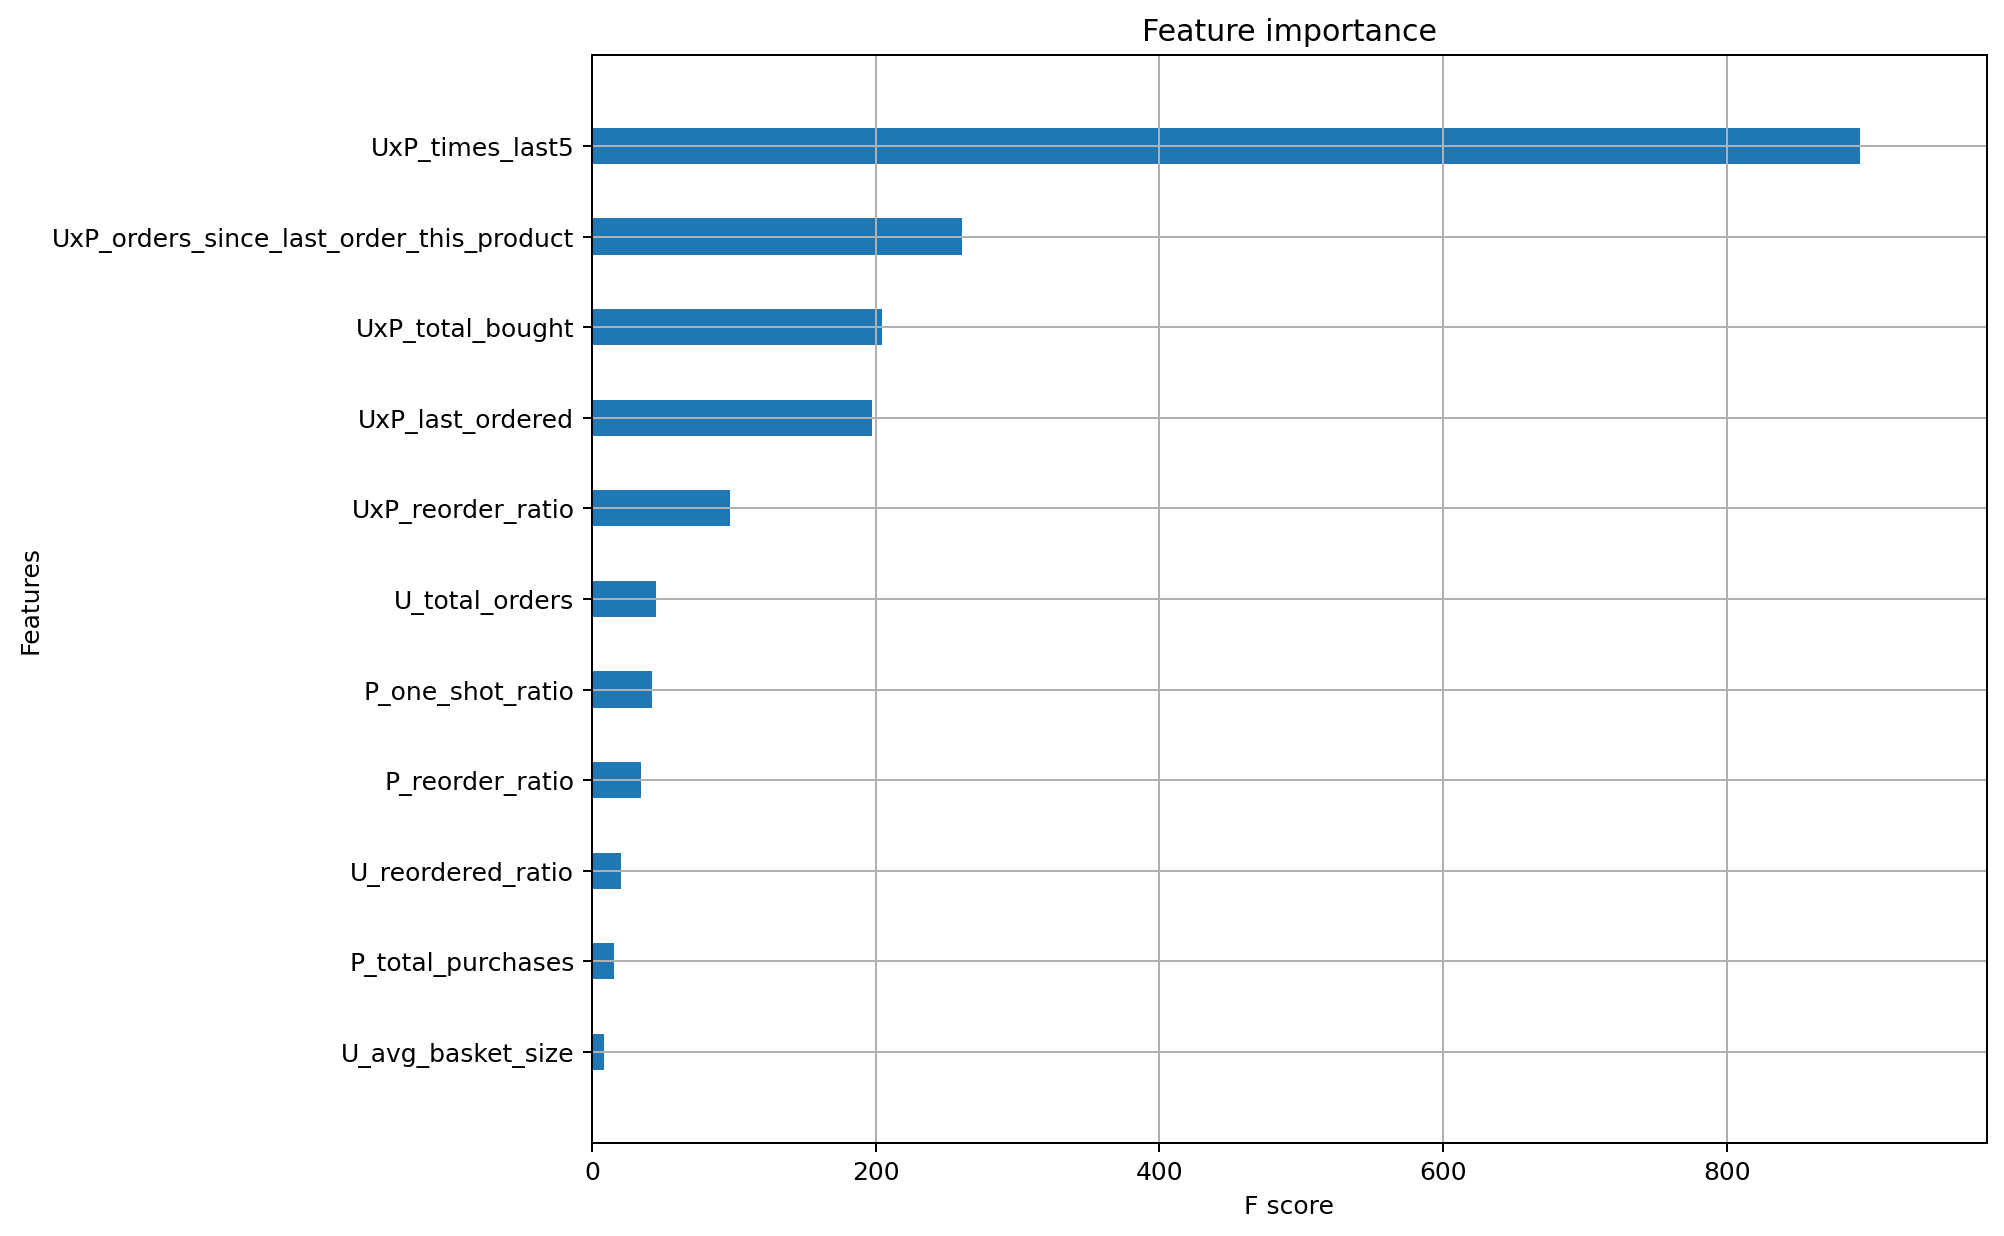

In [73]:
%matplotlib inline

fig, ax = pyplot.subplots(figsize=(10, 8), dpi=180)


plot_importance(best, height=0.4, importance_type='gain', max_num_features=30, show_values=False, ax=ax)

pyplot.show()